# Birmingham's population circles

Some graphs of the population of Birmingham vs the distance of the concentric circles around the central train station.


In [49]:
import requests
import json
import matplotlib.pyplot as plt
import pandas
from io import StringIO


Constants


In [50]:
POPULATION_API = (
    "https://ringpopulationsapi.azurewebsites.net/api/globalringpopulations"
)
MAX_KM = 50


Birmingham location


In [51]:
cities = pandas.read_csv("./data/worldcities/worldcities.csv", header=0)
bham = cities[cities["id"] == 1826423213]
bham_lat = bham["lat"].values[0]
bham_long = bham["lng"].values[0]
"Birmingham", bham_lat, bham_long


('Birmingham', 52.48, -1.9025)

Get data from API


In [57]:
# bham_lat = BIRMINGHAM_TRAIN_STATION_LOCATION["latitude"]
# bham_long = BIRMINGHAM_TRAIN_STATION_LOCATION["longitude"]
url = f"{POPULATION_API}?latitude={bham_lat}&longitude={bham_long}&distance_km={MAX_KM}"
print(f"getting...\n{url}")
request = requests.get(url)
bham_populations_json = json.loads(request.text)
print(f"got {len(bham_populations_json)} results...")

getting...
https://ringpopulationsapi.azurewebsites.net/api/globalringpopulations?latitude=52.48&longitude=-1.9025&distance_km=50
got 51 results...


Turn data from json into pandas


In [59]:
buf = StringIO(json.dumps(bham_populations_json))
df = pandas.read_json(buf)
df.set_index("distance", inplace=True)
# delete name column
df.drop(["name", "people_GB_Alt"], axis=1, inplace=True)
df.sort_index(inplace=True)
# add "difference" column (row - row above)
df["difference"] = df["people"] - df["people"].shift(1)
df.tail(3)


,people,busStops,tramStops,railStops,difference
distance,,,,,
48,5248879,23489,68,168,74859.0
49,5324772,23856,68,172,75893.0
50,5383761,24094,68,172,58989.0


Plot


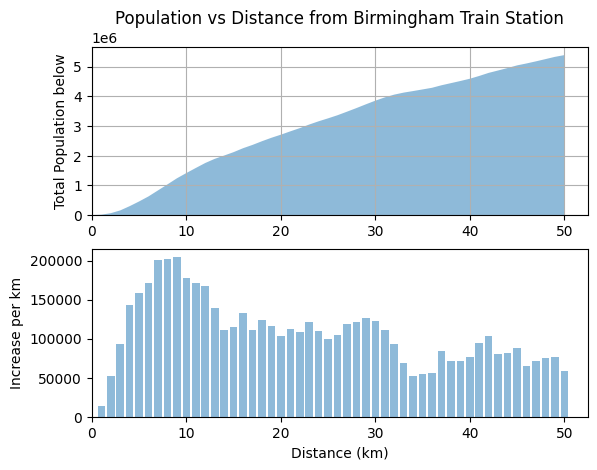

In [60]:
fig = plt.figure()

ax1 = fig.add_subplot(211)
ax1.fill_between(df.index, df["people"], label="Total population", alpha=0.5)
ax1.set_title("Population vs Distance from Birmingham Train Station")
ax1.set_ylabel("Total Population below")
ax1.set_ylim(bottom=0)
ax1.set_xlim(left=0)
ax1.grid()

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.bar(
    df.index,
    df["difference"],
    label="Per ring",
    alpha=0.5,
)
ax2.set_xlabel("Distance (km)")
ax2.set_ylabel("Increase per km")
ax2.set_ylim(bottom=0)

plt.show()

The above graph doesn't say very much, since "distance" is linear but each increase in distance increases the area a lot more, due to things being 2D and stuff.

Let's get that as a function of area instead.


In [61]:
df["area"] = df.index * df.index * 3.14159265359
df["density"] = df["people"] / df["area"]
df.tail(3)


,people,busStops,tramStops,railStops,difference,area,density
distance,,,,,,,
48,5248879,23489,68,168,74859.0,7238.229474,725.160624
49,5324772,23856,68,172,75893.0,7542.963961,705.925685
50,5383761,24094,68,172,58989.0,7853.981634,685.481740


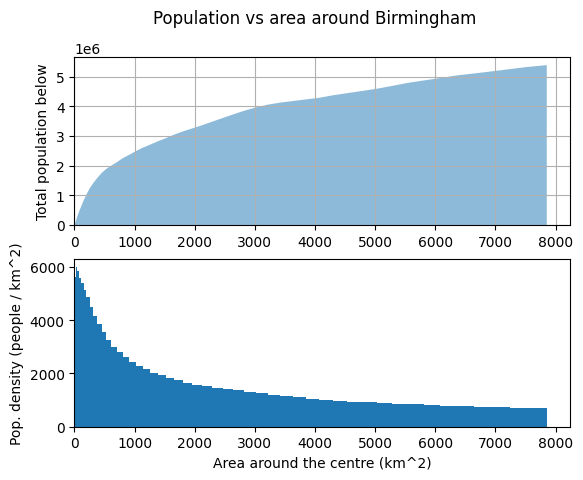

In [62]:
fig = plt.figure()
fig.suptitle("Population vs area around Birmingham")

ax1 = fig.add_subplot(211)
ax1.fill_between(df["area"], df["people"], label="Total population", alpha=0.5)
ax1.set_ylabel("Total population below")
ax1.grid()
ax1.set_ylim(bottom=0)
ax1.set_xlim(left=0)

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.hist(df["area"][:-1], df["area"], weights=df["density"][1:])
ax2.set_ylabel("Pop. density (people / km^2)")
ax2.set_xlabel("Area around the centre (km^2)")
ax2.set_ylim(bottom=0)
ax2.set_xlim(left=0)

plt.show()
